# A Decade of PSEI Price Performance: Using VADER Sentimental Analysis and Machine Learning for Forecasting.
By: John Klenn Andrew P. Dungaran \
Date: April 2024

## Introduction
My take on Task #7 from The Sparks Foundation - Graduate Rotational Internship Program, conducted in April 2024, involved analyzing Philippine news headlines from The Manila Times and correlating them with the PSEI Stock Index to identify trends and determine if the headlines have a significant impact on stock price movement. Additionally, I employed machine learning techniques to forecast future stock prices using various models.

## Sentimental and Numerical Analysis

### Data Preprocessing

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [11]:
# Import Data
df_stock = pd.read_csv('PSEI(2014-2024).csv')
df_news = pd.read_csv('PH_News(2014-2024).csv')

In [12]:
# Transform df_news
df_news['Date'] = pd.to_datetime(df_news['Date'])
df_news.dropna(inplace=True)
df_news = df_news.groupby('Date')['Title'].apply(lambda x: ' '.join(x)).reset_index()   # Concatenating titles & grouping by date
df_news

,Date,Title
0,2014-03-19,BOP position back to surplus in February PH go...
1,2014-03-20,Moody's sees PH 2014 GDP growth at 5.8% Moody'...
2,2014-03-21,Emerging economies’ crisis risky for Asia bond...
3,2014-03-23,Government may start policy tightening with SD...
4,2014-03-24,China to help PH build smart grid PSE poised f...
...,...,...
3474,2024-03-29,Hot money flows turn positive in Feb Fewer Fed...
3475,2024-03-30,BSP seen cutting 175 bps this year Fallen cryp...
3476,2024-03-31,US Fed's inflation fight remains on track – Po...
3477,2024-04-01,Poll: March inflation likely higher at 3.8% St...


In [13]:
# Transform df_stock
df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df_stock.dropna(inplace = True)
df_stock.drop(axis = 1, columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace = True)
df_stock

,Date,Close
0,2014-04-01,6514.720215
1,2014-04-02,6587.720215
2,2014-04-03,6587.080078
3,2014-04-04,6561.200195
4,2014-04-07,6614.399902
...,...,...
2561,2024-03-21,6963.220215
2562,2024-03-22,6881.970215
2563,2024-03-25,6853.100098
2564,2024-03-26,6898.169922


In [14]:
# Merging Data
df_merged = pd.merge(left = df_stock, right = df_news, how = 'left', left_on = 'Date', right_on = 'Date').dropna()
df_merged['Percentage_Change'] = df_merged['Close'].pct_change() * 100
df_merged.fillna(0, inplace=True)
df_merged

,Date,Close,Title,Percentage_Change
0,2014-04-01,6514.720215,Job creation remains PH’s biggest challenge – ...,0.000000
1,2014-04-02,6587.720215,Inflation Q1 average seen at 4.2%; to ease lat...,1.120539
2,2014-04-03,6587.080078,Meralco set to kick off power back-up plan for...,-0.009717
3,2014-04-04,6561.200195,The creative underworld Inflation slows to 3.9...,-0.392889
4,2014-04-07,6614.399902,US taper to persist in curbing PH growth PH sh...,0.810823
...,...,...,...,...
2431,2024-03-21,6963.220215,Inflation seen rising in March Poultry from Sw...,1.552483
2432,2024-03-22,6881.970215,BPI to unload GoTyme stake PH creative economy...,-1.166845
2433,2024-03-25,6853.100098,Boeing CEO to step down as safety concerns mou...,-0.419504
2434,2024-03-26,6898.169922,Economy seen growing faster Vingroup to launch...,0.657656


### VADER Sentiment Analysis

In [15]:
# Import nltk SentimentIntensityAnalyzer (VADER)
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# nltk.download('vader_lexicon')    #first time run
sia = SentimentIntensityAnalyzer()

In [16]:
# Run polarity score on the entire dataset
result = {}

for i, row in df_merged.iterrows():
        text = row['Title']
        date = row['Date']
        result[date] = sia.polarity_scores(text)['compound']
# result

In [17]:
# Merging polarity score into df_merged
df_vader = pd.DataFrame(list(result.items()), columns=['Date', 'Compound'])
df_vader.rename(columns={'Compound': 'Sentiment_Score'}, inplace=True)
df_merged_vader = pd.merge(left = df_merged, right = df_vader, how = 'left').set_index('Date')
df_merged_vader

,Close,Title,Percentage_Change,Sentiment_Score
Date,,,,
2014-04-01,6514.720215,Job creation remains PH’s biggest challenge – ...,0.000000,0.9341
2014-04-02,6587.720215,Inflation Q1 average seen at 4.2%; to ease lat...,1.120539,0.9349
2014-04-03,6587.080078,Meralco set to kick off power back-up plan for...,-0.009717,0.8910
2014-04-04,6561.200195,The creative underworld Inflation slows to 3.9...,-0.392889,0.9274
2014-04-07,6614.399902,US taper to persist in curbing PH growth PH sh...,0.810823,0.9236
...,...,...,...,...
2024-03-21,6963.220215,Inflation seen rising in March Poultry from Sw...,1.552483,0.6908
2024-03-22,6881.970215,BPI to unload GoTyme stake PH creative economy...,-1.166845,0.8126
2024-03-25,6853.100098,Boeing CEO to step down as safety concerns mou...,-0.419504,-0.9308


### Explaratory Data Analysis

The goal of exploratory data analysis (EDA) is to gain insight into the underlying patterns and trends in the data through visualizations and statistical summaries. This process helps to uncover relationships between variables, identify anomalies, and formulate hypotheses for further investigation.

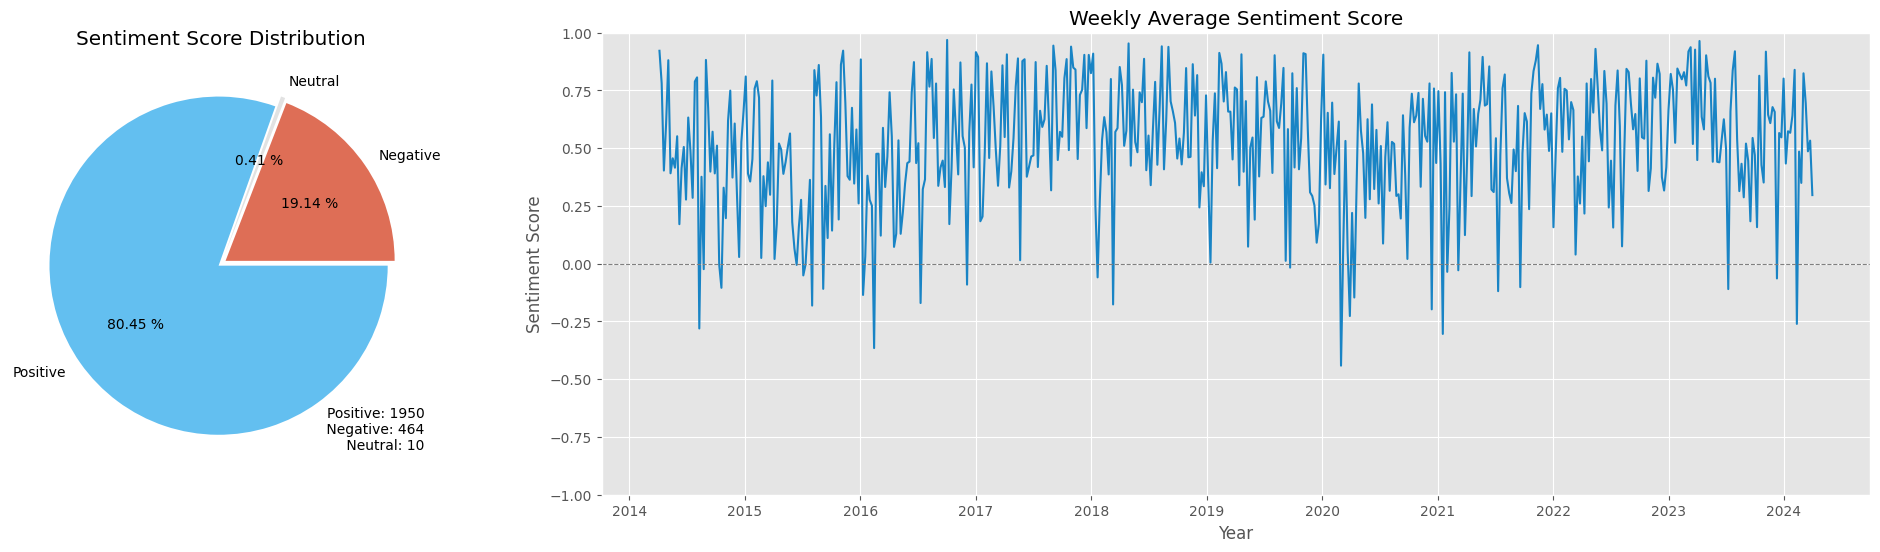

In [18]:
# Explaratory Data Analysis: Sentiment Score
fig, ax1 = plt.subplots(1, 2, figsize=(24, 6), gridspec_kw={'width_ratios': [1, 3]})

## Pie Chart for Sentiment Analysis
Negative = df_merged_vader.loc[df_merged_vader['Sentiment_Score'] < 0].count().iloc[0]
Neutral = df_merged_vader.loc[df_merged_vader['Sentiment_Score'] == 0].count().iloc[0]
Positive = df_merged_vader.loc[df_merged_vader['Sentiment_Score'] > 0].count().iloc[0]

labels = ['Negative', 'Neutral', 'Positive']
colors = ["#de6e56", "#e2e2e2", "#63bff0"]
explode = (0.03, 0.05, 0.02)

ax1[0].pie([Negative, Neutral, Positive], labels=labels, colors=colors, explode=explode, autopct='%.2f %%')
ax1[0].set_title('Sentiment Score Distribution')
ax1[0].set_aspect('equal')
ax1[0].text(1.2, -1.1, f'Positive: {Positive}\n Negative: {Negative}\n Neutral: {Neutral}', horizontalalignment='right')

## Line Chart for Sentiment Score
df_weekly = df_merged_vader.drop(axis=1, columns=['Title'])
df_weekly = df_weekly.resample('W').mean()

ax_x_01 = df_weekly.index
ax_y_01 = df_weekly['Sentiment_Score']

ax1[1].plot(ax_x_01, ax_y_01, color = '#1984c5')
ax1[1].axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax1[1].set_xlabel('Year')
ax1[1].set_ylabel('Sentiment Score')
ax1[1].set_ylim(-1, 1)
ax1[1].set_title('Weekly Average Sentiment Score')

plt.show()

Upon observing the Sentiment Score Distribution, it is evident that Philippine news headlines tend to lean more towards the positive side. Out of the total dataset, there are 1950 instances of positive scores, accounting for 80.45% of the data. Negative scores make up 19.14% of the dataset, while neutral scores are only 0.41%.

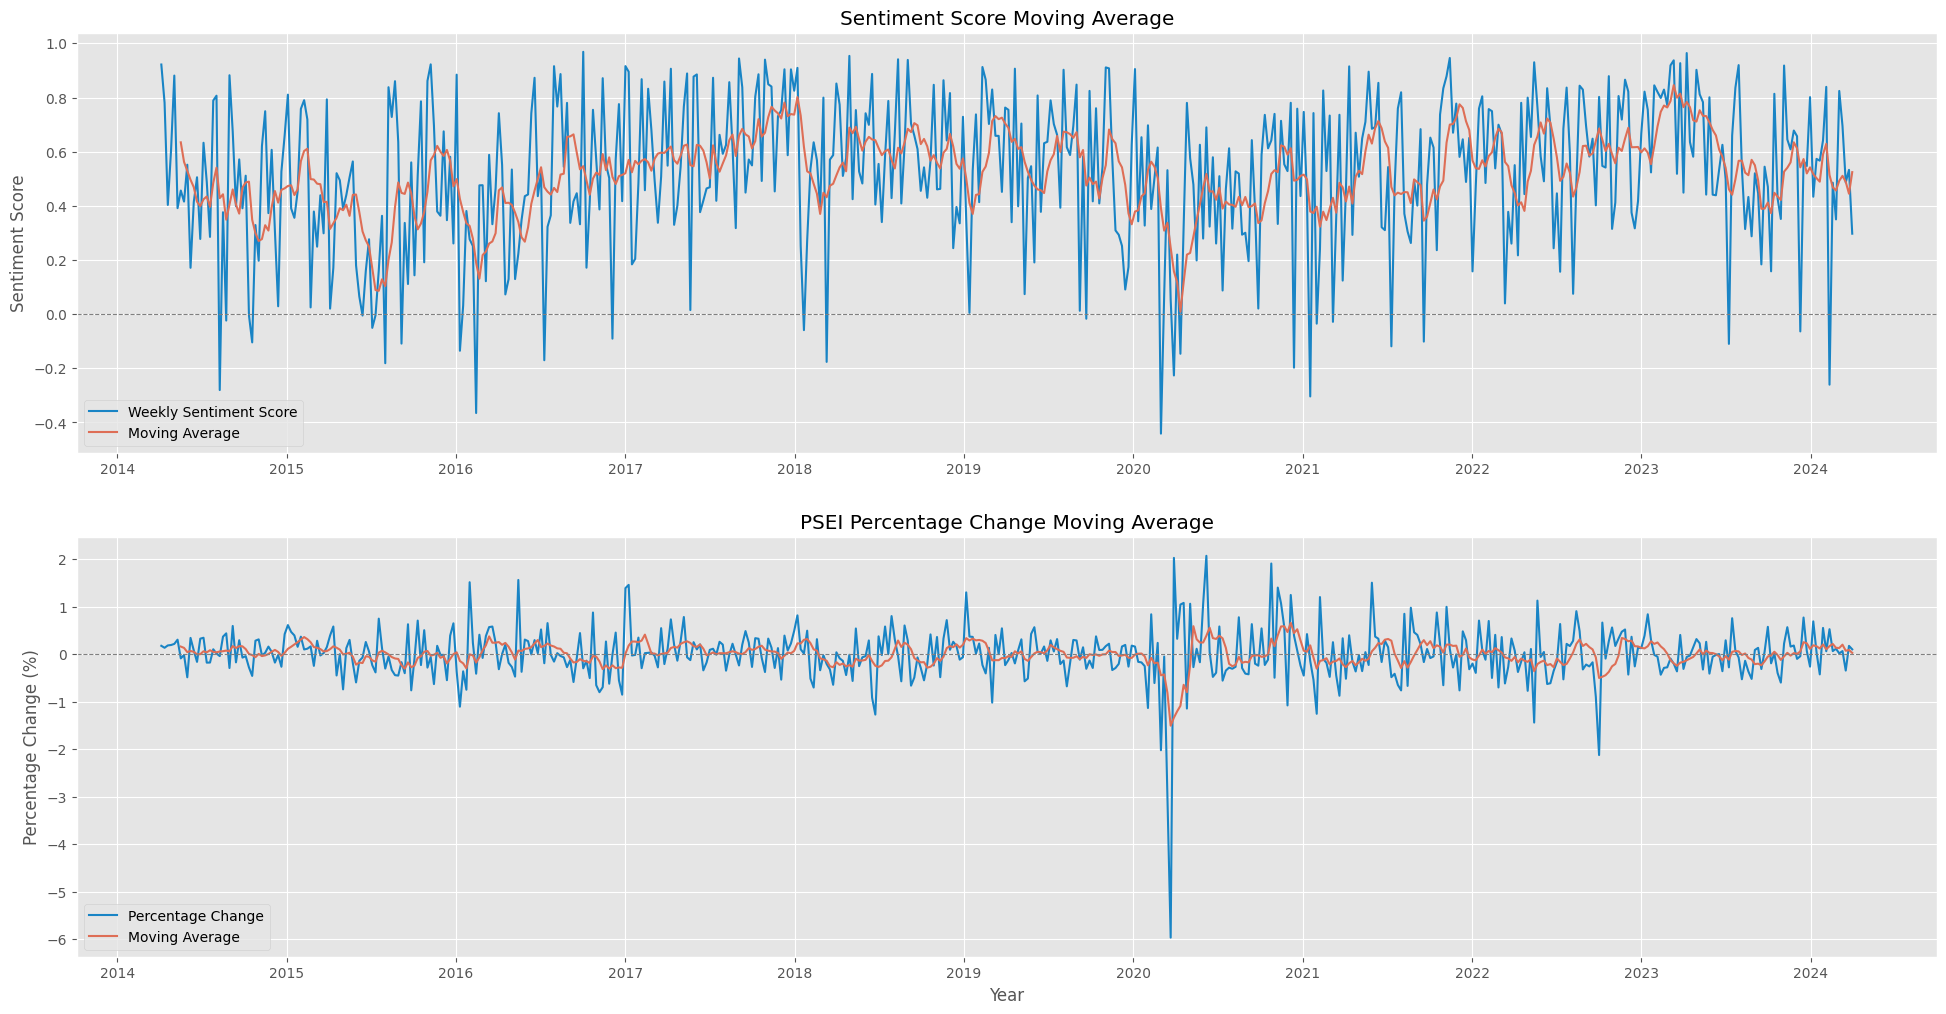

In [19]:
# Explaratory Data Analysis: Price Moving Average and Sentiment Score Moving Average
window_size = 7
price_ma = df_weekly['Percentage_Change'].rolling(window=window_size).mean()
senti_ma = df_weekly['Sentiment_Score'].rolling(window=window_size).mean()

plt.figure(figsize=(24, 12))

## Sentiment Score
ax_x_02 = df_weekly.index
ax_y_02 = df_weekly['Sentiment_Score']

plt.subplot(2,1,1)
plt.plot(ax_x_02, ax_y_02, color = '#1984c5', label = "Weekly Sentiment Score")
plt.plot(senti_ma, color = '#de6e56', label = 'Moving Average')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.ylabel('Sentiment Score')
plt.legend(loc = 'lower left')
plt.title('Sentiment Score Moving Average')

## Price
ax_x_03 = df_weekly.index
ax_y_03 = df_weekly['Percentage_Change']

plt.subplot(2,1,2)
plt.plot(ax_x_03, ax_y_03, color = '#1984c5', label = 'Percentage Change')
plt.plot(price_ma, color = '#de6e56', label = 'Moving Average')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.ylabel('Percentage Change (%)')
plt.xlabel('Year')
plt.legend(loc = 'lower left')
plt.title('PSEI Percentage Change Moving Average')

plt.show()

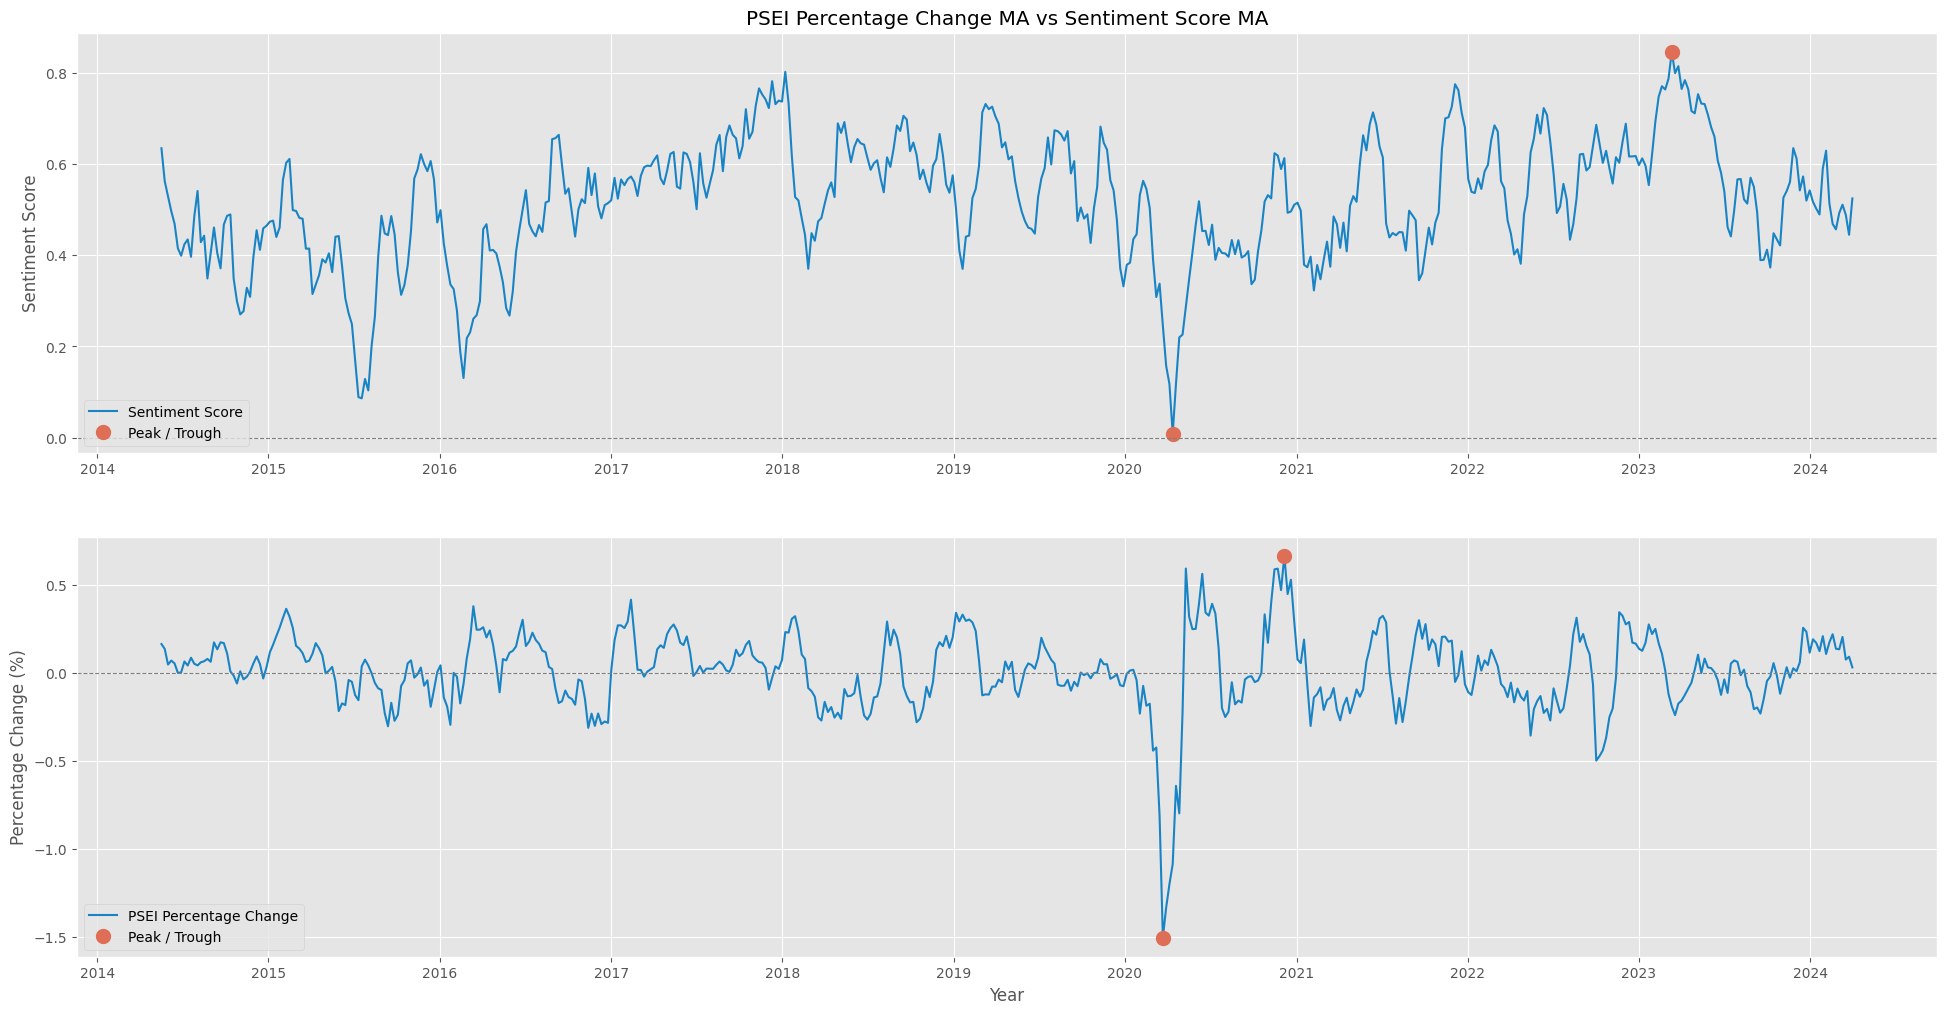

,Median,Mean,Max,Min
,,,,
Sentiment Score,0.524448,0.518740,0.845846,0.008861
Percentage Change,0.018147,0.010113,0.664162,-1.502570


In [20]:
# Explaratory Data Analysis: Comparison of Moving Averages

## Determining the summary of statistics
min_senti = senti_ma.min()
max_senti = senti_ma.max()
min_senti_date = senti_ma.idxmin()
max_senti_date = senti_ma.idxmax()
median_senti = senti_ma.median()
mean_senti = senti_ma.mean()

min_price = price_ma.min()
max_price = price_ma.max()
min_price_date = price_ma.idxmin()
max_price_date = price_ma.idxmax()
median_price = price_ma.median()
mean_price = price_ma.mean()

plt.figure(figsize=(24, 12))

## Sentiment Score
plt.subplot(2,1,1)
plt.plot(senti_ma, color='#1984c5', label='Sentiment Score')
plt.plot(min_senti_date, min_senti, 'o', color='#de6e56', label='Peak / Trough', markersize=10)
plt.plot(max_senti_date, max_senti, 'o', color='#de6e56', markersize=10)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.ylabel('Sentiment Score')
plt.subplots_adjust(hspace=0.2)
plt.legend(loc = 'lower left')
plt.title('PSEI Percentage Change MA vs Sentiment Score MA')

## Percentage Change
plt.subplot(2,1,2)
plt.plot(price_ma, color='#1984c5', label='PSEI Percentage Change')
plt.plot(min_price_date, min_price, 'o', color='#de6e56', label='Peak / Trough', markersize=10)
plt.plot(max_price_date, max_price, 'o', color='#de6e56', markersize=10)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.ylabel('Percentage Change (%)')
plt.legend(loc = 'lower left')
plt.xlabel('Year')

plt.show()

## Display Summary Statistics
summ = {' ': ['Sentiment Score', 'Percentage Change'], 
        'Median': [median_senti, median_price], 
        'Mean': [mean_senti, mean_price],
        'Max': [max_senti, max_price],
        'Min': [min_senti, min_price]}

df_summ = pd.DataFrame(summ).set_index(' ')
df_summ

Based on the statistical summary, the similarity between the median and mean suggests that there are likely few to no outliers present on the dataset. However, it's important to conduct further analysis, such as examining the distribution of the data and identifying any potential outliers, to confirm this observation.

Upon observing the comparison of the moving averages, both moving averages exhibit the same trough, indicating a consistent low point in the data. However, they show different peaks, suggesting variations in the high points of the data. It is worth noting that the peaks align with periods where both moving averages indicate a rising trend, which typically signifies a positive relationship.

Based on the result of the inspection, a hypothesis about the PSEI stock market price and Sentiment Score of PH news headlines can be drawn.

#### State Hypothesis
* Question: To what extent do Philippine news headlines influence the PSEI stock market price?

* Null Hypothesis (H0): There is no significant correlation between Philippine news headlines and the PSEI stock market price.

* Alternative Hypothesis (Ha): There is a significant correlation between Philippine news headlines and the PSEI stock market price.


### Correlation

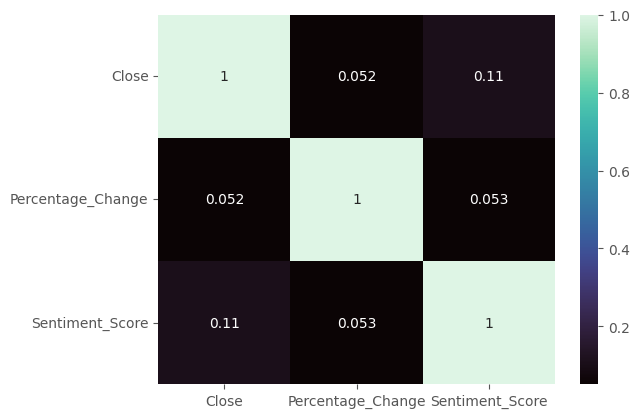

In [21]:
correlation = df_weekly.corr()
sns.heatmap(correlation, annot = True, cmap=sns.color_palette('mako', as_cmap=True));

The correlation heatmap reveals a negligible association between Philippine news headlines and the PSEI stock market price. Specifically, the correlation coefficient between the sentiment score and the closing price stands at a modest 0.11. Moreover, the correlation coefficient between the sentiment score and the percentage change is even lower, measuring at 0.053.

### Linear Regression Model

In [22]:
# Import SciKit-Learn Linear Regressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

regressor = LinearRegression()

In [23]:
# Splitting the dataset into the Training set and Testing set
x_true = df_weekly['Sentiment_Score'].to_frame()       # Independent Variable - Sentiment Score
y_true = df_weekly['Close'].to_frame()                 # Dependent Variable - PSEI Closing Price

X_train, X_test, y_train, y_test = train_test_split(x_true, y_true, test_size=0.2, random_state=0)

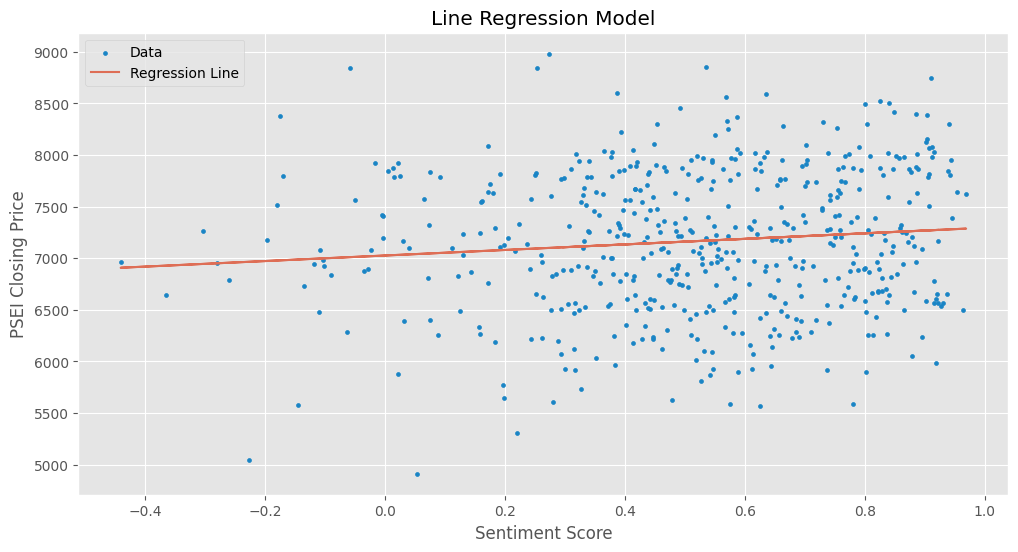

,Slope,Y-intercept,r2 Score,Mean Squared Error,Mean Absolute Error
,268.855377,7026.960461,-0.002386,424407.670444,524.58473


In [24]:
# Fitting the linear regression model
regressor.fit(X_train, y_train)

# Summary of Results
y_pred = regressor.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
slope = regressor.coef_[0]
y_intercept = regressor.intercept_

coeff_summ = {'Slope': slope[0],
              'Y-intercept': y_intercept[0],
              'r2 Score': r2,
              'Mean Squared Error': mse,
              'Mean Absolute Error': mae}

df_coeff = pd.DataFrame(coeff_summ, index=[' '])

# Linear Regression Plot
reg_line = y_intercept + slope * df_weekly['Sentiment_Score']

plt.figure(figsize=(12, 6))

plt.scatter(df_weekly['Sentiment_Score'], df_weekly['Close'], color='#1984c5', label='Data', s=8)
plt.plot(df_weekly['Sentiment_Score'], reg_line, color='#de6e56', label='Regression Line')
plt.ylabel('PSEI Closing Price')
plt.xlabel('Sentiment Score')
plt.legend(loc='upper left')
plt.title('Line Regression Model')

plt.show()
df_coeff

FROM THE SCATTER PLOT WE CAN SEE THAT THERE IS REALLY NO CLEAR PATTERN OF THE SENTIMENT SCORE TO DRAW A LINE -- ADD THIS INSIGHT


A very low R-squared and large MSE suggest that the linear regression model is not performing well on the given data and may require further refinement or a different approach to improve its predictive power.

### Key Findings

* From the exploratory data analysis (EDA), the Philippine news headlines tend to skew more towards positive sentiment. This suggests that the news media in the Philippines may have a tendency to report more positive news or frame events in a positive light. 

* The moving average of sentiment scores has a different peak compared to the moving average of the stock market percentage change. This discrepancy in peaks suggests that there may not be a direct or immediate correlation between the sentiment of news headlines and the performance of the stock market

* Based on the observed correlation coefficients and the lack of a strong relationship between Philippine news sentiment and PSEI stock market fluctuations, it is reasonable to suggest that the null hypothesis, which posits little to no correlation between the two variables, is likely correct. 

* The poor performance of the linear regression model (indicated by the low R-squared and large MSE) could further suggest that news headlines do not have a significant impact on stock prices, at least not in a linear relationship that the model is trying to capture.

However, it's important to note that while a poor model performance can be suggestive, it does not conclusively prove the null hypothesis. Other factors could be influencing the relationship between news headlines and stock prices that are not captured by the model, which could be a topic for another research.


## Forecasting

### ARIMA Forecasting Model

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

plt.style.use('ggplot')

In [26]:
# Read & Pre-Process Dataset
df_stock = pd.read_csv('PSEI(2014-2024).csv')
df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df_stock = df_stock.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume']).dropna().sort_values(by='Date').set_index('Date')
df_stock

,Close
Date,
2014-04-01,6514.720215
2014-04-02,6587.720215
2014-04-03,6587.080078
2014-04-04,6561.200195
2014-04-07,6614.399902
...,...
2024-03-21,6963.220215
2024-03-22,6881.970215
2024-03-25,6853.100098


## Collection of Parameters

### ADF Test
We'll use the Augumented Dickey Fuller (ADF) test to check if the time series is stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.

In [27]:
# Check if the price series is stationary
result = adfuller(df_stock)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.781051502805296
p-value: 0.061031817544298185


Since p-value > 0.05, we need to find the degree of differencing.

In [28]:
# Using ndiffs from pmdarima to find the degree of differencing (d)
d = ndiffs(df_stock, test='adf')
print(f'Degree of Differencing: {d}')

# Differencing the data and re-checking results
df_diff = df_stock['Close'].diff().dropna()

result = adfuller(df_diff)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

Degree of Differencing: 1
ADF Statistic: -22.838193329112862
p-value: 0.0


Now we need to find the p and q values through observation of the PACF and ACF plots

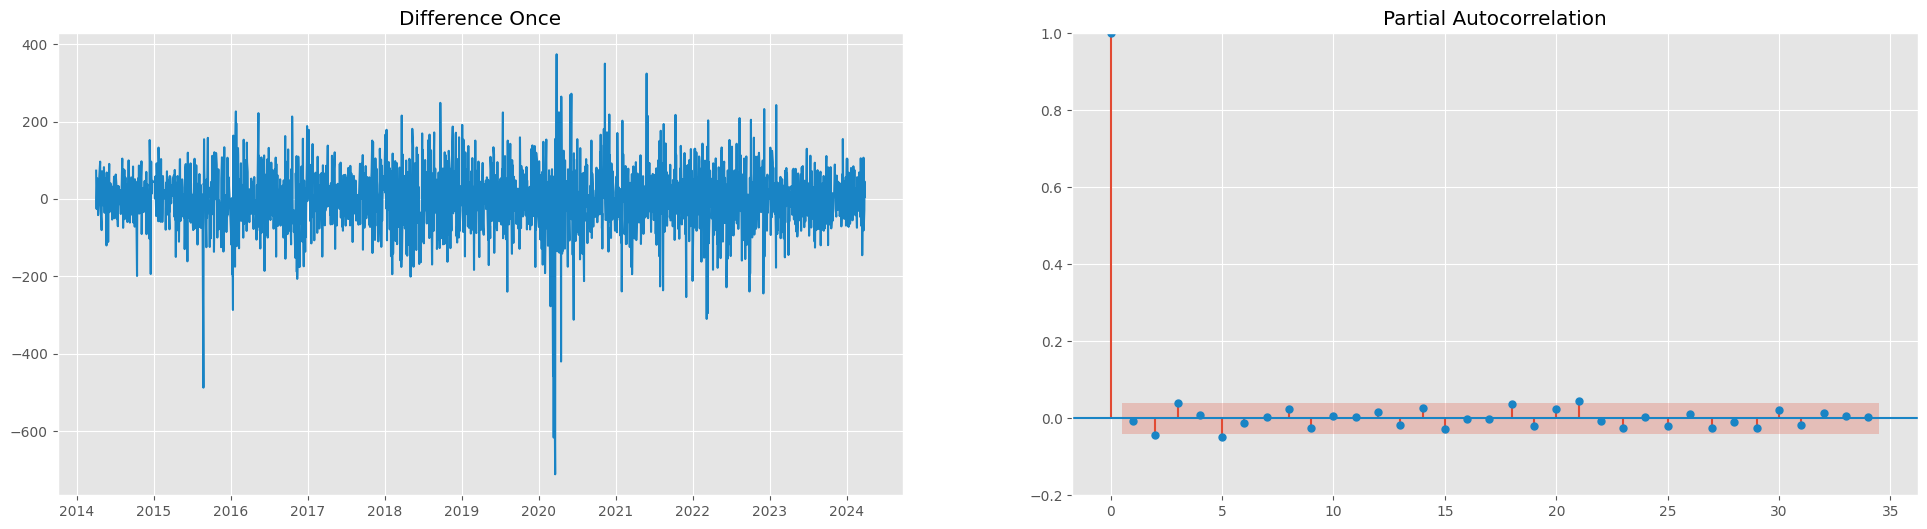

In [29]:
# Ploting PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

ax1.plot(df_diff, color='#1984c5')
ax1.set_title('Difference Once')
plot_pacf(df_diff, ax=ax2, color='#1984c5')
ax2.set_ylim(-0.2, 1)
plt.show()

From observing the PACF plot, the order of the autoregressive model `p = 2`

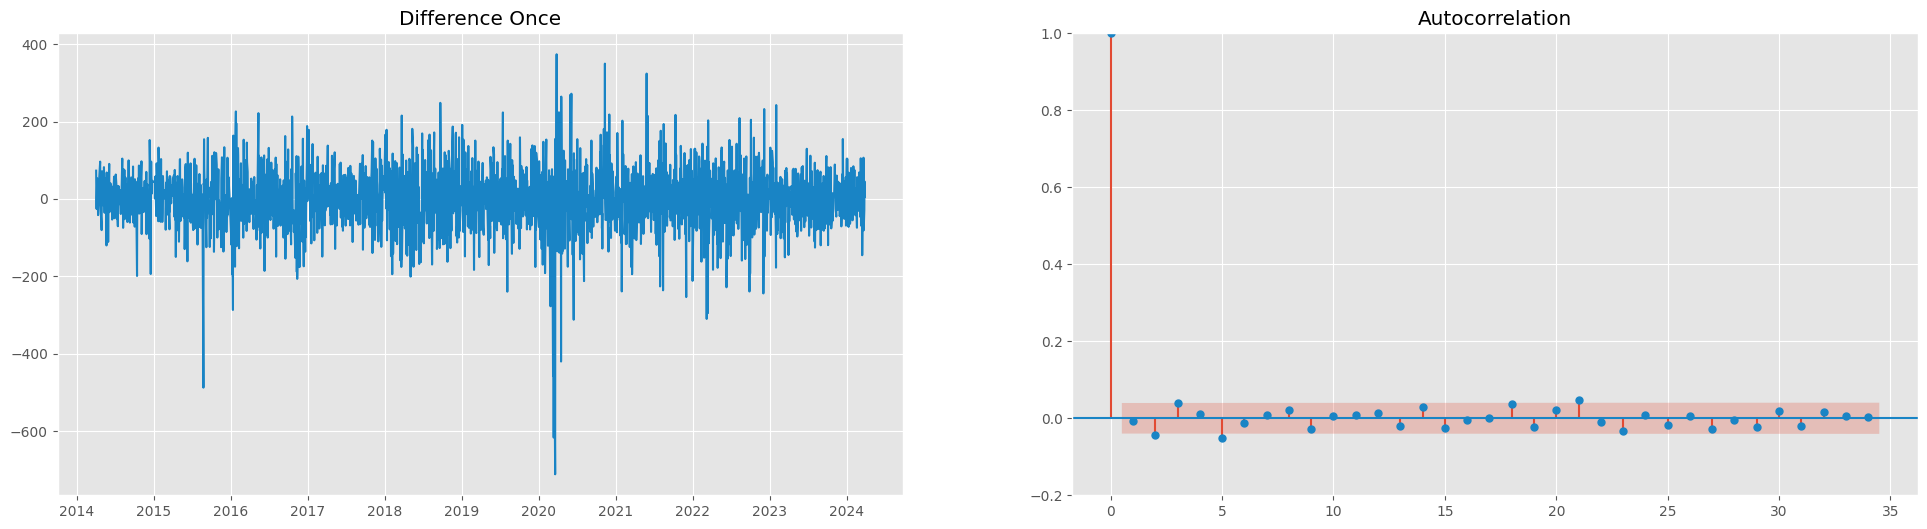

In [30]:
# Plotting the ACF Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

ax1.plot(df_diff, color='#1984c5')
ax1.set_title('Difference Once')
plot_acf(df_diff, ax=ax2, color='#1984c5')
ax2.set_ylim(-0.2, 1)
plt.show()

From observing the ACF plot, the order of the moving-average model `q = 3`

## Model Training

In summary from the previous step, we will be implementing the ARIMA model since we have all 3 required parameters. These parameters are:
* Order of the autoregressive model `p = 2`
* Degree of differencing `d = 1`
* Order of the moving-average model `q = 3`

In [31]:
model = ARIMA(df_stock['Close'].values, order=(2, 1, 3))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2436
Model:                 ARIMA(2, 1, 3)   Log Likelihood              -14101.221
Date:                Wed, 10 Apr 2024   AIC                          28214.441
Time:                        12:07:05   BIC                          28249.227
Sample:                             0   HQIC                         28227.087
                               - 2436                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4267      0.023    -18.416      0.000      -0.472      -0.381
ar.L2         -0.9611      0.022    -43.799      0.000      -1.004      -0.918
ma.L1          0.4221      0.029     14.721      0.0

## Results

### Accuracy

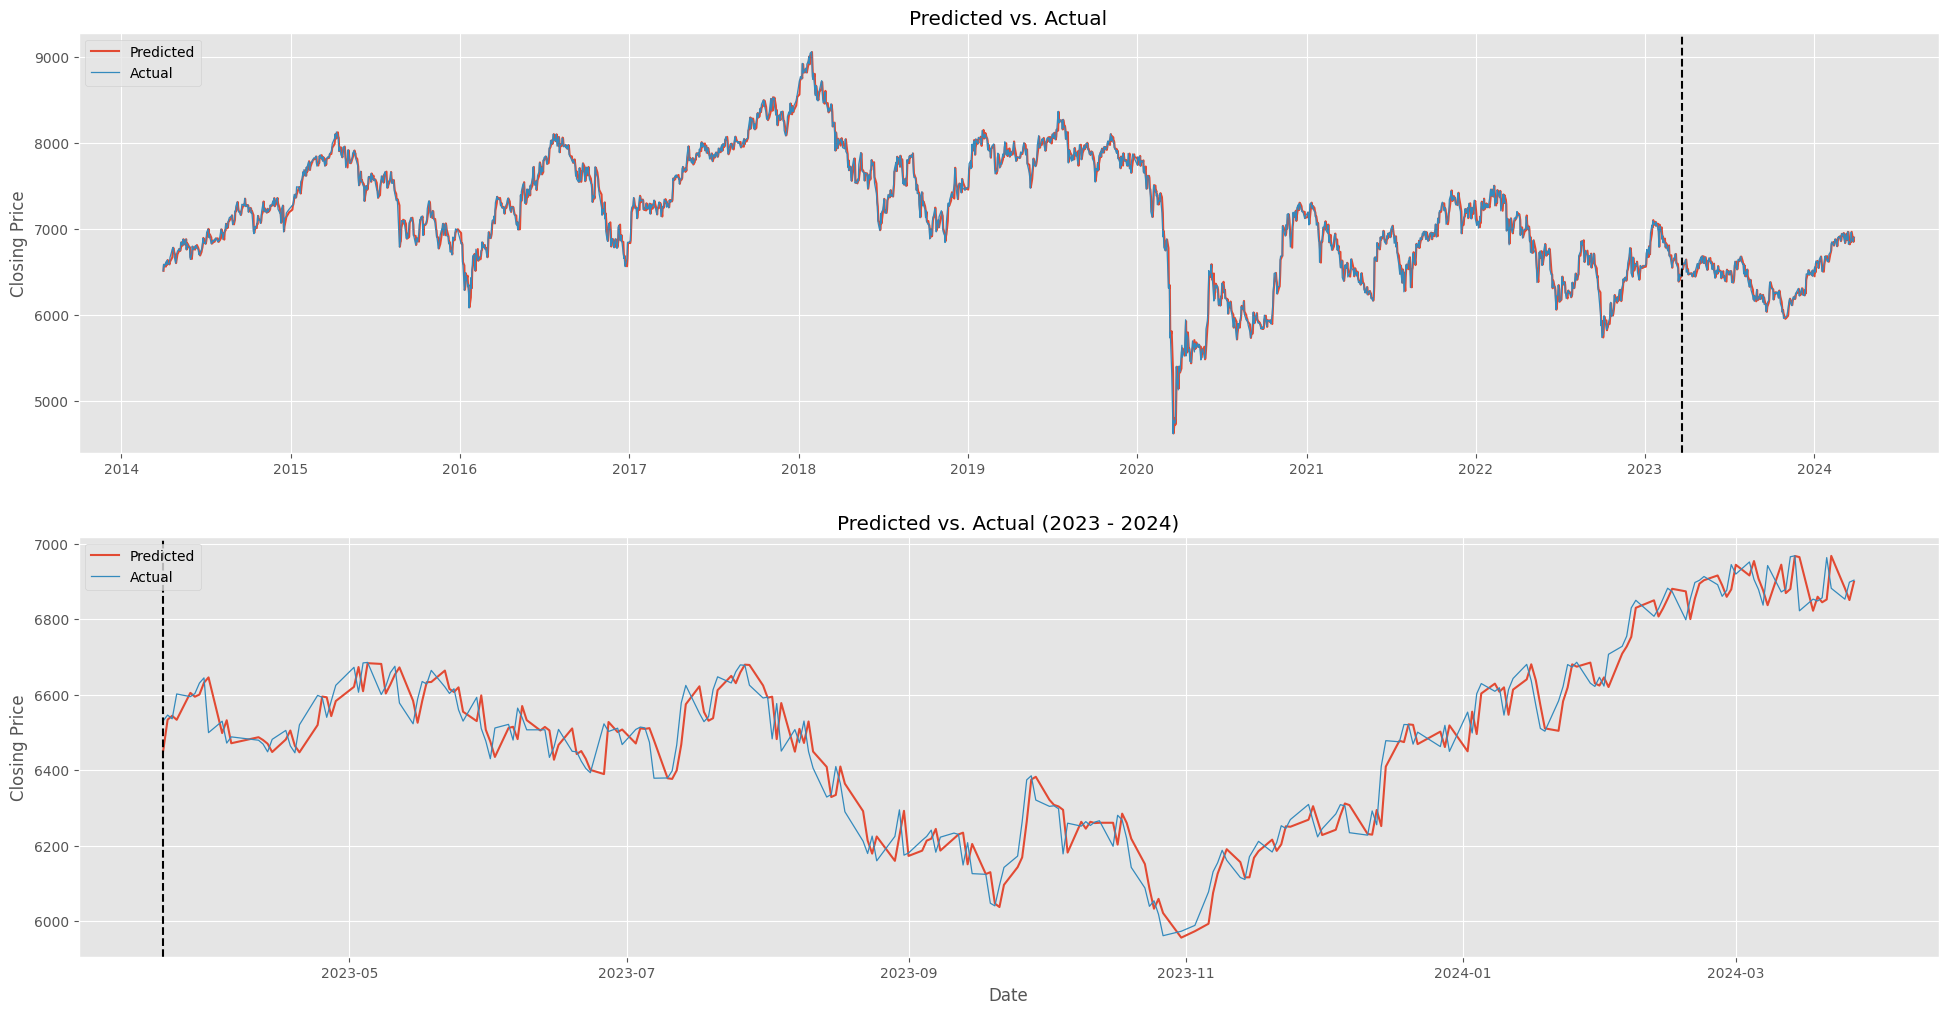

In [32]:
df_stock['Predicted'] = result.predict(dynamic=False)

plt.figure(figsize=(24, 12))

plt.subplot(2, 1 ,1)
plt.plot(df_stock['Predicted'][1:], label='Predicted')
plt.plot(df_stock['Close'], label='Actual', lw=0.9)
plt.ylabel('Closing Price')
plt.axvline(df_stock.index[2186:2187], color='black', ls='--')
plt.title('Predicted vs. Actual')
plt.legend(loc='upper left')

plt.subplot(2, 1 ,2)
plt.plot(df_stock['Predicted'][2186:], label='Predicted')
plt.plot(df_stock['Close'][2186:], label='Actual', lw=0.9)
plt.ylabel('Closing Price')
plt.xlabel('Date')
plt.axvline(df_stock.index[2186:2187], color='black', ls='--')
plt.title('Predicted vs. Actual (2023 - 2024)')
plt.legend(loc='upper left')

plt.show()

In [33]:
# Statistical Metrics
r2 = r2_score(df_stock['Close'], df_stock['Predicted'])
mae = mean_absolute_error(df_stock['Close'], df_stock['Predicted'])
mape = mean_absolute_percentage_error(df_stock['Close'], df_stock['Predicted'])

print(f'R-Squared: {r2}')
print(f'MAE: {mae}')
print(f'MAPE: {mape * 100}')

R-Squared: 0.9499702281497232
MAE: 60.85957005657869
MAPE: 0.871746911027909


* R-Squared: A value of 0.95 indicates that the model explains 95% of the variance in the stock prices. This suggest the the model is performing well in predicting stock prices.
* Mean Absolute Error: A value of 60.86 indicates that on average the model's prediction are off by approximately 60.86.
* Mean Absolute Percentage Error: A value of 0.87% implies that the model is about 99.13% accurate in predicting the observations.

### Forecast

We will only be forecasting 30 days into the future since ARIMA is not that reliable in forecasting long term.

In [34]:
forecast = result.forecast(steps=23)
last_date = df_stock.index[-1]
future_date = pd.bdate_range(start=last_date + pd.DateOffset(days=1), periods=23)
df_forecast = pd.DataFrame()
df_forecast['Date'] = future_date
df_forecast['Close'] = forecast
df_forecast

,Date,Close
0,2024-03-28,6904.076161
1,2024-03-29,6902.472671
2,2024-04-01,6902.630324
3,2024-04-02,6904.104155
4,2024-04-03,6903.323790
5,2024-04-04,6902.240269
6,2024-04-05,6903.452581
7,2024-04-08,6903.976678
8,2024-04-09,6902.587919
9,2024-04-10,6902.676763


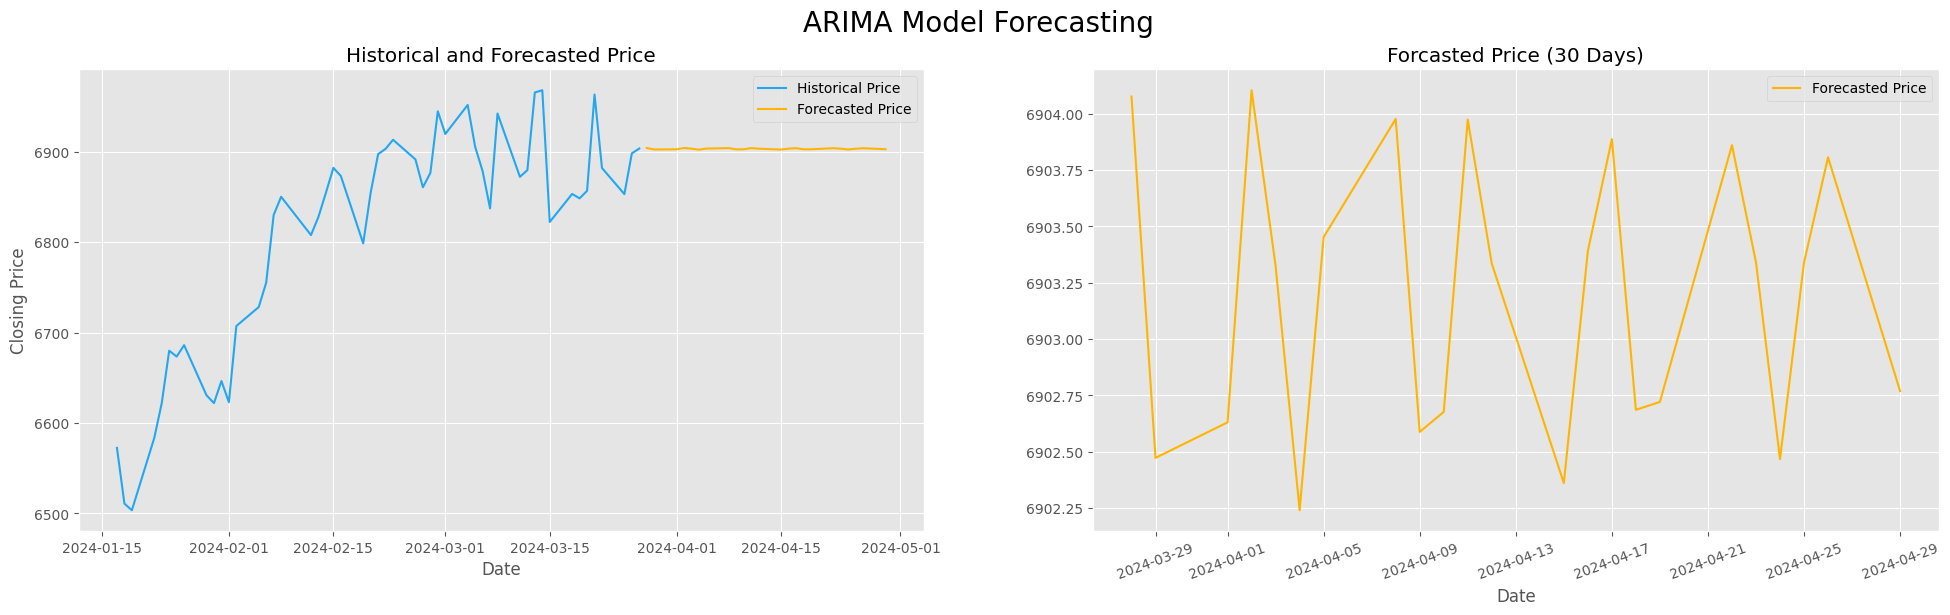

In [35]:
# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,6))

ax1.plot(df_stock.index[2386:], df_stock['Close'][2386:], color='#22a7f0', label='Historical Price')
ax1.plot(df_forecast['Date'], df_forecast['Close'], color='#ffb400', label='Forecasted Price')
ax1.set_title('Historical and Forecasted Price')
ax1.set_ylabel('Closing Price')
ax1.set_xlabel('Date')
ax1.legend(loc='upper right')

ax2.plot(future_date, forecast, color='#ffb400' ,label='Forecasted Price')
ax2.set_title('Forcasted Price (30 Days)')
ax2.set_xlabel('Date')
ax2.legend(loc='upper right')
ax2.tick_params(axis='x', rotation=20)

fig.suptitle('ARIMA Model Forecasting', fontsize=20)
plt.show()